# Setup

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [7]:
def grab(x):
    return x.detach().cpu().numpy()

In [8]:
def compute_ess(w):
    return (w.mean()**2) / (w**2).mean()

# Phi4 theory

Copied from Lecture 1:

In [9]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        # phi.shape = (Lx, Ly, ...)
        Nd = len(phi.shape)
        S = ((Nd + self.m2/2) * phi**2 + (self.lam/24) * phi**4).sum()
        for mu in range(Nd):
            phi_fwd = torch.roll(phi, -1, dims=mu)
            S -= (phi * phi_fwd).sum()
        return S

In [10]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2)*pi
    for _ in range(n_leap-1):
        pi -= dt*action.grad(phi)
        phi += dt*pi
    pi -= dt*action.grad(phi)
    phi += (dt/2)*pi

Modified to keep L as a parameter, and return samples $\phi$ and associated action values:

In [11]:
def run_hmc(action, *, L, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    torch.manual_seed(1234)
    phi = 0.1*torch.randn((L, L)) # warm start
    S = action.value(phi)
    acc = 0
    tot = 0
    meas = []
    phis = []
    actions = []
    for i in tqdm.tqdm(range(-n_therm, n_iter)):
        new_phi = phi.clone()
        pi = torch.randn_like(phi)
        K = (pi**2/2).sum()
        leapfrog_update(new_phi, pi, action, dt=dt, n_leap=n_leap)
        Sp = action.value(new_phi)
        Kp = (pi**2/2).sum()
        dH = grab(Sp + Kp - S - K)
        tot += 1
        if np.random.random() < np.exp(-dH): # accept
            phi = new_phi
            S = Sp
            acc += 1
        if i >= 0 and (i+1)%n_meas == 0:
            meas.append(grab(phi.mean()))
            phis.append(grab(phi))
            actions.append(S)
            # print(f'Acc {100.0*acc/tot:.2f}')
    return dict(meas=np.stack(meas), phis=np.stack(phis), actions=np.stack(actions))

# Flow

In [33]:
class Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        conv_kwargs = dict(kernel_size=3, padding=1, padding_mode='circular')
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(2, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 1, **conv_kwargs),
        )
    def value(self, x, t):
        inp = torch.stack([x, torch.ones_like(x)*t])
        return self.net(inp)[0]
    def div(self, x, t):
        shape = x.shape
        x_flat = x.flatten()
        def eval_flat(y):
            x = y.reshape(shape)
            inp = torch.stack([x, torch.ones_like(x)*t])
            return self.net(inp)[0].flatten()
        J = torch.func.jacfwd(eval_flat)(x_flat)
        return torch.trace(J)

In [34]:
velocity = Velocity()
phi = torch.randn((4, 4))
print(velocity.value(phi, 1.0))
print(velocity.div(phi, 1.0))

tensor([[-0.1019, -0.0761, -0.1321, -0.0563],
        [-0.0313, -0.0984, -0.0606, -0.0586],
        [-0.0422,  0.0085, -0.0432, -0.0089],
        [-0.0932, -0.1234, -0.1094, -0.1322]], grad_fn=<SelectBackward0>)
tensor(-0.0739, grad_fn=<TraceBackward0>)


Copied from Lecture 2:

In [35]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

In [36]:
# chunk size makes sure we do not try to evaluate all samples at
# the same time, exhausting our memory
flow_batch = torch.func.vmap(flow, in_dims=(0, None), chunk_size=512)
flow_batch(torch.randn((1, 4, 4)), velocity, n_step=10)

(tensor([[[-0.9161, -0.8878,  0.2328,  0.4058],
          [ 0.9116, -0.3545,  0.1946, -1.1683],
          [-0.8795, -1.9096, -1.6217, -1.8762],
          [ 0.9550, -0.0280,  0.3433, -1.5395]]], grad_fn=<CatBackward0>),
 tensor([-0.0572], grad_fn=<CatBackward0>))

  0%|          | 0/1100 [00:00<?, ?it/s]

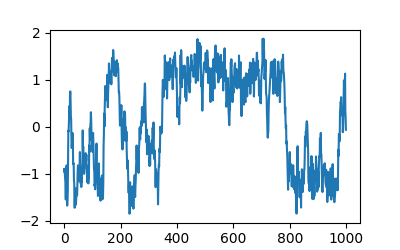

In [16]:
# our target will be in the broken phase
target = Phi4Action(-0.5, 1.5)
res_hmc = run_hmc(target, L=4, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)
fig, ax = plt.subplots(1,1, figsize=(4,2.5))
ax.plot(res_hmc['meas'])
plt.show()

We will approach the target by learning 5 different flows trained to transport between the $m^2 = 0, \lambda = 1.5$ theory (symmetric phase) and the $m^2 = -0.5, \lambda = 1.5$ theory (broken phase) in steps of $m^2$:
$$
(m^2, \lambda) = (0, 1.5) \; \longrightarrow \; (-0.1, 1.5) \; \longrightarrow \; (-0.2, 1.5) \; \longrightarrow \; (-0.3, 1.5) \; \longrightarrow \; (-0.4, 1.5) \; \longrightarrow \; (-0.5, 1.5)
$$

In [17]:
targets = [Phi4Action(m2, 1.5) for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]]

In [18]:
def train_model(prior, target, *, batch_size=4, n_iter=1000):
    torch.manual_seed(1234)
    model = Velocity()
    L = 4
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_hist = []
    ess_hist = []
    flow_batch = torch.func.vmap(flow, in_dims=(0, None))
    target_batch = torch.func.vmap(target.value)
    prior_batch = torch.func.vmap(prior.value)
    res_hmc = run_hmc(prior, L=L, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)
    prior_samples = res_hmc['phis']
    prior_actions = res_hmc['actions']
    for i in tqdm.tqdm(range(n_iter)):
        opt.zero_grad()
        # sample prior
        inds = np.random.randint(len(prior_samples), size=batch_size)
        xr = torch.tensor(prior_samples[inds])
        logr = -torch.tensor(prior_actions[inds])
        # flow
        x, logJ = flow_batch(xr, model, n_step=10)
        logp = -target_batch(x)
        # ordinary kl logq
        # logq = logr - logJ
        # path grad logq
        model.requires_grad_(False)
        xr2, logJ2 = flow_batch(x, model, n_step=10, inverse=True)
        model.requires_grad_(True)
        logq = -prior_batch(xr2) - logJ2
        # kl div
        loss = (logq - logp).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        ess = compute_ess((logp - logq).exp())
        ess_hist.append(grab(ess))
        if (i+1) % 25 == 0:
            print(f'Step {i+1}: Loss {grab(loss)} ESS {grab(ess)}')
    fig, axes = plt.subplots(1,2, figsize=(8, 3))
    axes[0].plot(loss_hist)
    axes[1].plot(ess_hist)
    axes[0].set_ylabel('loss')
    axes[1].set_ylabel('ess')
    return dict(model=model, loss=np.stack(loss_hist), ess=np.stack(ess_hist))

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.3908609449863434 ESS 0.9844096302986145
Step 50: Loss -0.36737746000289917 ESS 0.9948413968086243
Step 75: Loss -0.30603593587875366 ESS 0.9641997218132019
Step 100: Loss -0.3884633779525757 ESS 0.9944501519203186
Step 125: Loss -0.35628896951675415 ESS 0.9917745590209961
Step 150: Loss -0.41198307275772095 ESS 0.9920343160629272
Step 175: Loss -0.3932439088821411 ESS 0.9932912588119507
Step 200: Loss -0.398017019033432 ESS 0.9912046194076538


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.4234447181224823 ESS 0.9812030792236328
Step 50: Loss -0.3599005341529846 ESS 0.9514968395233154
Step 75: Loss -0.3915867209434509 ESS 0.9532164931297302
Step 100: Loss -0.43680644035339355 ESS 0.988527774810791
Step 125: Loss -0.44310006499290466 ESS 0.9853204488754272
Step 150: Loss -0.450006902217865 ESS 0.981855034828186
Step 175: Loss -0.38763898611068726 ESS 0.9923781752586365
Step 200: Loss -0.4225730001926422 ESS 0.9800586104393005


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.5543772578239441 ESS 0.948764979839325
Step 50: Loss -0.5962321758270264 ESS 0.9625566005706787
Step 75: Loss -0.5488260388374329 ESS 0.973447859287262
Step 100: Loss -0.5097596645355225 ESS 0.9645267128944397
Step 125: Loss -0.5103427171707153 ESS 0.9664506316184998
Step 150: Loss -0.552649736404419 ESS 0.96553635597229
Step 175: Loss -0.5082461833953857 ESS 0.9455459713935852
Step 200: Loss -0.5269090533256531 ESS 0.9707443714141846


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.5481852889060974 ESS 0.9053847193717957
Step 50: Loss -0.6385329961776733 ESS 0.9352329969406128
Step 75: Loss -0.6180863380432129 ESS 0.933346688747406
Step 100: Loss -0.7066446542739868 ESS 0.9402589201927185
Step 125: Loss -0.6782083511352539 ESS 0.9504525661468506
Step 150: Loss -0.6700801849365234 ESS 0.9235856533050537
Step 175: Loss -0.6285314559936523 ESS 0.9510459303855896
Step 200: Loss -0.7111427783966064 ESS 0.9378038644790649


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.9288114309310913 ESS 0.9116063714027405
Step 50: Loss -0.8077776432037354 ESS 0.8632256984710693
Step 75: Loss -0.8674063086509705 ESS 0.9015966653823853
Step 100: Loss -0.9782284498214722 ESS 0.9059731960296631
Step 125: Loss -0.8241981267929077 ESS 0.9144623875617981
Step 150: Loss -0.8337705731391907 ESS 0.8842490315437317
Step 175: Loss -0.9320551156997681 ESS 0.9400348663330078
Step 200: Loss -0.9039652347564697 ESS 0.9177367091178894


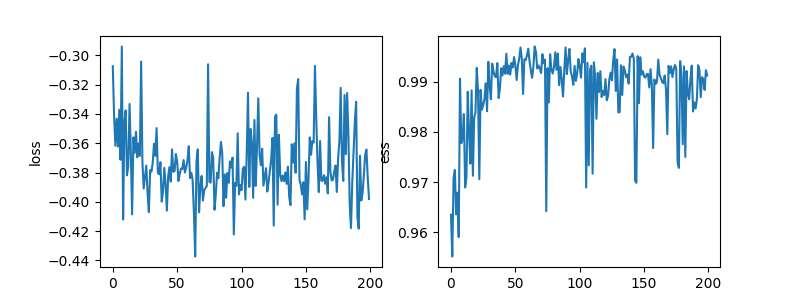

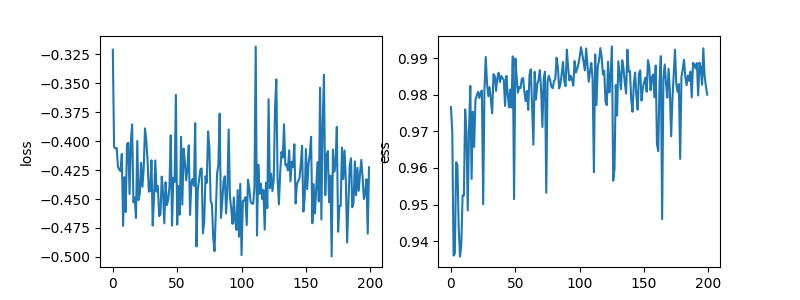

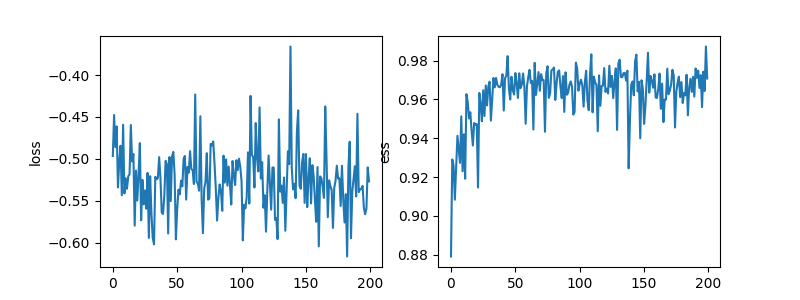

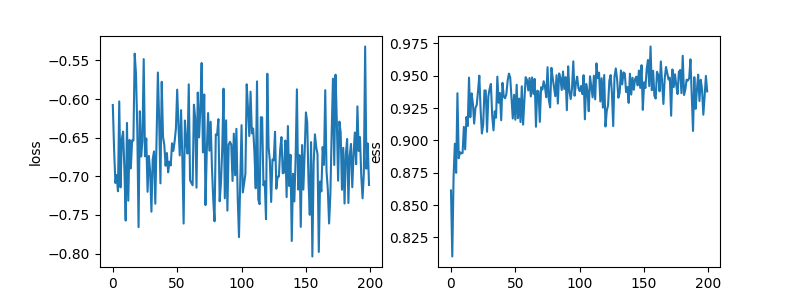

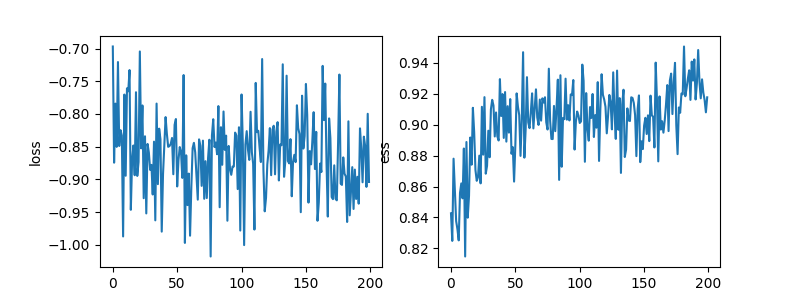

In [19]:
results = [
    train_model(targets[i], targets[i+1], batch_size=32, n_iter=200)
    for i in range(len(targets)-1)
]

# Evaluate

## L = 4

In [20]:
prior = Phi4Action(0.0, 1.5)
phi_r = torch.tensor(run_hmc(prior, L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20)['phis'])
logr = -torch.func.vmap(prior.value)(phi_r)

  0%|          | 0/5100 [00:00<?, ?it/s]

In [43]:
def apply_flows(phi_r):
    samples = [phi_r]
    ws = [torch.ones(phi_r.shape[0])]
    for res, target_p, target in zip(tqdm.tqdm(results), targets[:-1], targets[1:]):
        with torch.no_grad(): # we don't need gradients, so don't waste memory for it
            phi, logJ = flow_batch(samples[-1].clone(), res['model'], n_step=100)
        dlogq = -logJ
        dlogp = -torch.func.vmap(target.value)(phi) + torch.func.vmap(target_p.value)(samples[-1])
        ws.append(ws[-1] * (dlogp - dlogq).exp())
        samples.append(phi)
        print(f'ess: {compute_ess(ws[-1])}')
    return dict(samples=samples, ws=ws)

In [22]:
res_L4 = apply_flows(phi_r)

  0%|          | 0/5 [00:00<?, ?it/s]

ess: 0.99222731590271
ess: 0.9578012824058533
ess: 0.8642480373382568
ess: 0.677585780620575
ess: 0.4607026278972626


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

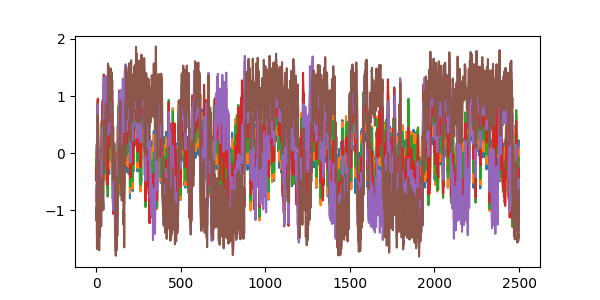

In [23]:
# compare with 2500 samples from the HMC
target = Phi4Action(-0.5, 1.5)
res_hmc_L4 = []
fig, ax = plt.subplots(1,1, figsize=(6, 3))
for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]:
    res_hmc_L4.append(run_hmc(Phi4Action(m2, 1.5), L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20))
    ax.plot(res_hmc_L4[-1]['meas'])
plt.show()

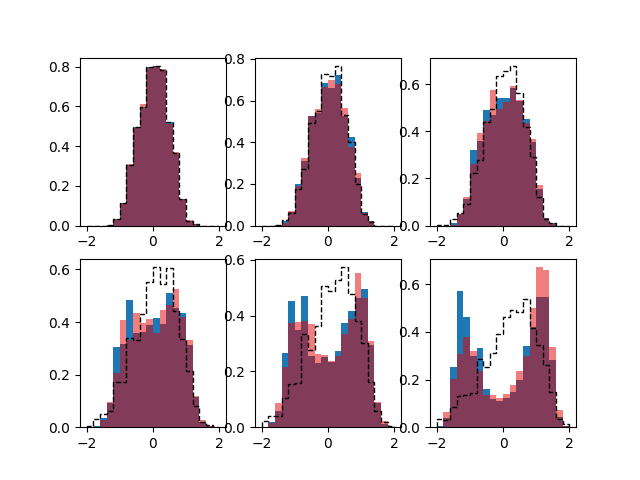

In [24]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, res_hmc in zip(axes, res_L4['samples'], res_L4['ws'], res_hmc_L4):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(res_hmc['meas'], density=True, bins=bins, alpha=0.5, color='xkcd:red')
plt.show()

**EXERCISE:** We will introduce HMC updates between each flow to improve the results. This framework is known as "stochastic normalizing flows".

In [25]:
def apply_stoch_flows(phi_r):
    samples = [phi_r]
    ws = [torch.ones(phi_r.shape[0])]
    for res, target_p, target in zip(tqdm.tqdm(results), targets[:-1], targets[1:]):
        with torch.no_grad(): # we don't need gradients, so don't waste memory for it
            phi, logJ = flow_batch(samples[-1].clone(), res['model'], n_step=100)
        dlogq = -logJ
        dlogp = -torch.func.vmap(target.value)(phi) + torch.func.vmap(target_p.value)(samples[-1])
        ws.append(ws[-1] * (dlogp - dlogq).exp())
        # before saving samples, improve them with an HMC update
        for i in tqdm.tqdm(range(len(phi))):
            new_phi = phi[i].clone()
            pi = torch.randn_like(phi[i])
            S = target.value(phi[i])
            K = (pi**2/2).sum()
            leapfrog_update(new_phi, pi, target, dt=0.05, n_leap=50)
            Sp = target.value(new_phi)
            Kp = (pi**2/2).sum()
            dH = grab(Sp + Kp - S - K)
            if np.random.random() < np.exp(-dH): # accept
                phi[i] = new_phi
        # now, save samples
        samples.append(phi)
        print(f'ess: {compute_ess(ws[-1])}')
    return dict(samples=samples, ws=ws)

In [26]:
res_snf_L4 = apply_stoch_flows(phi_r)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.99222731590271


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.9762122631072998


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.9407542943954468


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.8577985167503357


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.7363221645355225


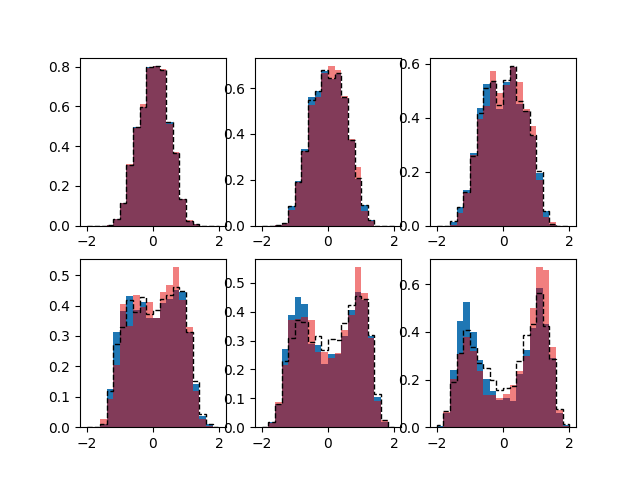

In [27]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, res_hmc in zip(axes, res_snf_L4['samples'], res_snf_L4['ws'], res_hmc_L4):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(res_hmc['meas'], density=True, bins=bins, alpha=0.5, color='xkcd:red')
plt.show()

Conclusion: The ESS is better and the actual distribution of samples after the SNF properly captures the multi-modal distribution!

## L = 8

**EXERCISE:** Because we worked with convolutions, the _same_ flow model can be directly applied to the L=8 theory. The result is not great, but could be improved by scaling up the model, training more, and/or trying to build a specialized model to target the Z2 spontaneous symmetry breaking of the theory.

In [41]:
prior = Phi4Action(0.0, 1.5)
phi_r = torch.tensor(run_hmc(prior, L=8, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20)['phis'])
logr = -torch.func.vmap(prior.value)(phi_r)

  0%|          | 0/5100 [00:00<?, ?it/s]

In [42]:
# reduce number of samples for the sake of time
res_L8 = apply_flows(phi_r[::10])

  0%|          | 0/5 [00:00<?, ?it/s]

samples[-1].shape=torch.Size([250, 8, 8])
phi.shape=torch.Size([250, 8, 8])
ess: 0.9597930312156677
samples[-1].shape=torch.Size([250, 8, 8])
phi.shape=torch.Size([250, 8, 8])
ess: 0.769618570804596
samples[-1].shape=torch.Size([250, 8, 8])
phi.shape=torch.Size([250, 8, 8])
ess: 0.3662651777267456
samples[-1].shape=torch.Size([250, 8, 8])
phi.shape=torch.Size([250, 8, 8])
ess: 0.11584579944610596
samples[-1].shape=torch.Size([250, 8, 8])
phi.shape=torch.Size([250, 8, 8])
ess: 0.046096071600914


In [ ]:
# compare with 250 samples from the HMC
target = Phi4Action(-0.5, 1.5)
res_hmc_L8 = []
fig, ax = plt.subplots(1,1, figsize=(6, 3))
for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]:
    res_hmc_L8.append(run_hmc(Phi4Action(m2, 1.5), L=8, n_therm=100, n_iter=1000, n_meas=4, dt=0.05, n_leap=20))
    ax.plot(res_hmc_L8[-1]['meas'])
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, hmc_data in zip(axes, samples, ws, res_hmc_L8):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(hmc_data['meas'], bins=bins, density=True, color='xkcd:red', alpha=0.5)
plt.show()

# U(1) flow

**EXERCISE:** We want to sample from a von Mises distribution described by
$$
p(\theta) = \frac{1}{2 \pi I_0(\beta)} e^{\beta \cos(\theta)}
$$
in terms of the modified Bessel function $I_0(\beta)$. This is very similar to the toy flow problem from before, but we need to ensure the velocity network is appropriately periodic as a function of $\theta$ and that we integrate $\theta$ correctly.

In [44]:
import scipy as sp
import scipy.special # gives us Bessel function for normalization

In [66]:
class VMTarget:
    def __init__(self, beta):
        self.beta = beta
    def log_prob(self, theta):
        return self.beta * torch.cos(theta) - np.log(2*np.pi*sp.special.iv(0, self.beta))
    def sample(self, batch_size):
        return torch.tensor(np.random.vonmises(0, self.beta, size=(batch_size,)))

In [67]:
class U1Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 1),
        )
    def value(self, theta, t):
        inp = torch.stack([torch.cos(theta), torch.sin(theta), t])
        return self.net(inp)[0]
    def div(self, theta, t):
        J = torch.func.jacfwd(self.value, argnums=0)(theta, t)
        # in this case J is just a scalar
        return J

In [70]:
def u1_train_model(target, n_step=1000, batch_size=32):
    model = U1Velocity()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    logp_batch = torch.func.vmap(target.log_prob)
    loss_hist = []
    for i in tqdm.tqdm(range(n_step)):
        opt.zero_grad()
        # prior = uniform
        xr = 2*np.pi*torch.rand((batch_size,))
        x, logJ = flow_batch(xr, model, n_step=10)
        logp = logp_batch(x)
        # path gradients
        model.requires_grad_(False)
        xr2, logJ2 = flow_batch(x, model, n_step=10, inverse=True)
        model.requires_grad_(True)
        logr = -np.log(2*np.pi)
        logq = logr - logJ2
        loss = (logq - logp).mean()
        loss.backward()
        opt.step()
        # metrics
        loss_hist.append(grab(loss))
    return dict(model=model, loss_hist=np.stack(loss_hist))

In [71]:
target = VMTarget(3.0)
res = u1_train_model(target)

  0%|          | 0/1000 [00:00<?, ?it/s]

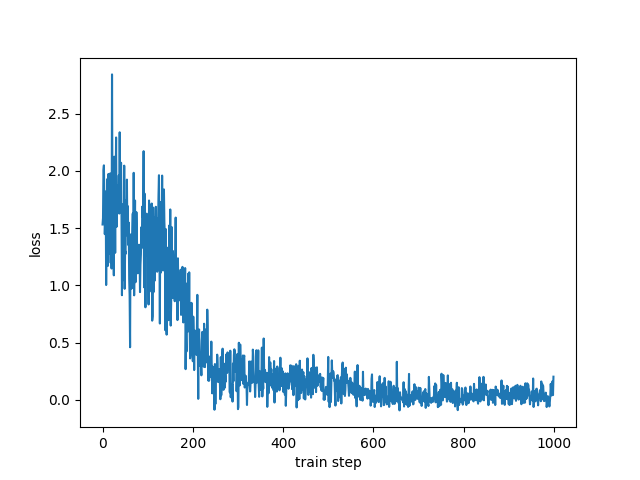

In [80]:
fig, ax = plt.subplots(1,1)
ax.plot(res['loss_hist'])
ax.set_ylabel('loss')
ax.set_xlabel('train step')
plt.show()

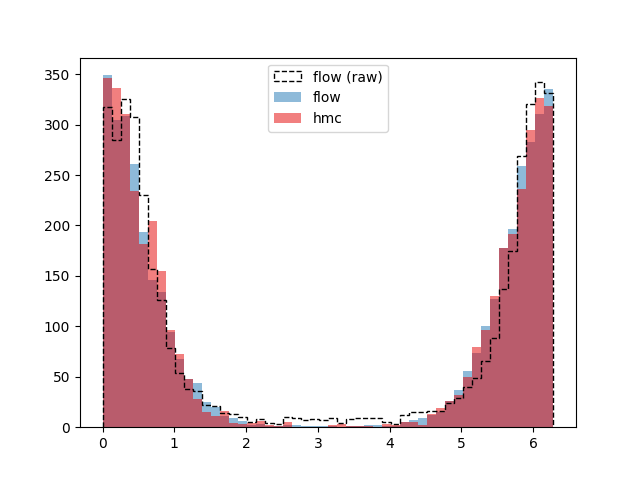

In [79]:
# compare histogram of samples from model vs target
theta_target = target.sample(4096)
xr = 2*np.pi*torch.rand((4096,))
theta_flow, logJ = flow_batch(xr, res['model'], n_step=100)
logp = torch.func.vmap(target.log_prob)(theta_flow)
logq = -np.log(2*np.pi) - logJ
w = np.exp(grab(logp - logq))
fig, ax = plt.subplots(1,1)
bins = np.linspace(0, 2*np.pi, num=51)
ax.hist(grab(theta_flow % (2*np.pi)), bins=bins, histtype='step', color='k', linestyle='--', label='flow (raw)')
ax.hist(grab(theta_flow % (2*np.pi)), bins=bins, weights=w, alpha=0.5, label='flow')
ax.hist(grab(theta_target % (2*np.pi)), bins=bins, color='xkcd:red', alpha=0.5, label='hmc')
ax.legend(loc='upper center')
plt.show()